In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd 
import numpy as np
import spacy
import string
import pickle as pkl
from sklearn import preprocessing
import os.path
from operator import add
from collections import Counter
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

if os.getcwd() != '/content/drive/My Drive/NLU':
  %cd 'drive/My Drive/NLU'

In [0]:
!pip install sacremoses
import torch.optim as optim
import numpy as np
import os
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

In [0]:
blogs = pd.read_csv("blogtext.csv.zip")
blogs.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [0]:
#creating labels, 1 is ages 13-17, 2 is ages 23-27, 3 is 33-47

#first create a list of indicators for each age bracket 
def create_age_bracket(lower_bound, upper_bound):
    under_upper = 1*(blogs['age'] <=upper_bound)
    over_lower = 1*(blogs['age'] >=lower_bound)

    return 1*((under_upper + over_lower) == 2)

ones = create_age_bracket(13,17)
twenties = create_age_bracket(23,27)
thirties = create_age_bracket(33,47)

print('there are', np.sum(ones), 'blog posts from people aged 13-17')
print('there are', np.sum(twenties), 'blog posts from people aged 23-27')
print('there are', np.sum(thirties), 'blog posts from people aged 33-47')

#creating 'label' column by combining indicator lists
blogs['label'] = ones + 2*twenties +3*thirties

#removing instances that don't fit the age buckets
blogs = blogs[blogs['label'] != 0]
blogs.columns[6]

there are 235867 blog posts from people aged 13-17
there are 321447 blog posts from people aged 23-27
there are 120398 blog posts from people aged 33-47


'text'

In [0]:
#making training, validation, and test sets (70%,15%,15% split)
np.random.seed(23)

n = blogs.shape[0]
train_size = int(n*.7)
val_size = int(n*.15)
test_size = n - train_size-val_size

train_ids = np.random.choice(n, replace=False, size=train_size)
test_val_ids = np.asarray(list((set(np.arange(n)) - set(train_ids))))
val_ids = np.random.choice(a=test_val_ids, replace=False, size=val_size)
test_ids = np.array(list(set(test_val_ids)-set(val_ids)))

train_df = blogs.iloc[train_ids]
val_df = blogs.iloc[val_ids]
test_df = blogs.iloc[test_ids]

print('size of training set:', train_df.shape[0])
print('size of validation set:',val_df.shape[0])
print('size of test set:', test_df.shape[0])

size of training set: 474398
size of validation set: 101656
size of test set: 101658


In [0]:
# This is the code cell that tokenizes train/val/test datasets

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    count = 0
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

        count += 1
        if count%1000 == 0:
          print(count)

    return token_dataset, all_tokens

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation


In [0]:
#splitting training set into two in order to perform preproccessing
train_df = train_df.reset_index(drop=True)
n = train_df.shape[0]
chunk_size = int(n/4)

chunks = {}
chunks[1] = train_df['text'][0:chunk_size]
chunks[2] = train_df['text'][chunk_size: 2*chunk_size]
chunks[3] = train_df['text'][2*chunk_size: 3*chunk_size]
chunks[4] = train_df['text'][3*chunk_size:]

In [0]:
#saving tokenized data as pickle files
if not os.path.exists('val_tokens.p'):
    print("Tokenizing validation data")
    val_tokens, _ = tokenize_dataset(val_df['text'])
    pkl.dump(val_tokens, open("val_tokens.p", "wb"))

    print("Tokenizing test data")
    val_tokens, _ = tokenize_dataset(test_df['text'])
    pkl.dump(val_tokens, open("test_tokens.p", "wb"))

if not os.path.exists('all_tokens_4.p'):
    for i in range(4):
        print("tokenizing chunk " + str(i+1))
        train_tokens, train_all_tokens = tokenize_dataset(chunks[i+1])
        pkl.dump(train_tokens, open("train_tokens_"+ str(i+1) +".p", "wb"))
        pkl.dump(train_all_tokens, open("all_tokens_" +str(i+1) +".p", "wb"))

In [0]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 10000

#creating pickle files for id2token and token2id dictionaries
if not os.path.exists('id2token.p'):
    token_dct = {}
    index_dct = {}
    for i in range(4):
        print(i)
        all_tokens = pkl.load(open("all_tokens_" + str(i+1) +".p", "rb"))
        for token in all_tokens:
            if token in token_dct.keys():
                token_dct[token] += 1
            else:
                token_dct[token] = 0

    id2token = ['<pad>', '<unk>'] + sorted(token_dct, key=token_dct.get, reverse=True)[:max_vocab_size]

    count = 0
    for token in id2token:
        index_dct[token] = count
        count += 1



    pkl.dump(id2token, open("id2token.p", "wb"))
    pkl.dump(index_dct, open("token2id.p","wb"))

In [0]:
token2id = pkl.load(open("token2id.p", "rb"))
id2token = pkl.load(open("id2token.p", "rb"))

In [0]:
def token2index_dataset(tokens_data,token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

#creating and pickling fully tokenized data
if not os.path.exists('tokenized_test_data.p'):
    tokenized_train_data = []
    for i in range(4):
        print(i)
        train_tokens = pkl.load(open("train_tokens_" + str(i+1)+".p", "rb"))

        tokenized_train_data += token2index_dataset(train_tokens, token2id)

    print(len(tokenized_train_data))
    pkl.dump(tokenized_train_data, open("tokenized_train_data.p", "wb"))
  
    val_tokens = pkl.load(open("val_tokens.p", "rb"))
    tokenized_val_data = token2index_dataset(val_tokens, token2id)

    test_tokens = pkl.load(open("test_tokens.p", "rb"))
    tokenized_test_data = token2index_dataset(test_tokens, token2id)

    pkl.dump(tokenized_val_data, open("tokenized_val_data.p", "wb"))
    pkl.dump(tokenized_test_data, open("tokenized_test_data.p", "wb"))

In [0]:
#start 

tokenized_train_data = pkl.load(open("tokenized_train_data.p", "rb"))
tokenized_val_data = pkl.load(open("tokenized_val_data.p", "rb"))
tokenized_test_data = pkl.load(open("tokenized_test_data.p", "rb"))

#train_labels = 1*(np.array(train_df['gender']) == 'male')
#val_labels = 1*(np.array(val_df['gender']) == 'male')
#test_labels = 1*(np.array(test_df['gender']) == 'male')

#age labels
train_labels = np.array(train_df['label']) - 1
val_labels = np.array(val_df['label']) - 1
test_labels = np.array(test_df['label']) - 1

In [0]:
MAX_SENTENCE_LENGTH = 250
class BlogDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list,):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

In [0]:
train_dataset = BlogDataset(tokenized_train_data, train_labels)
val_dataset = BlogDataset(tokenized_val_data, val_labels)
test_dataset = BlogDataset(tokenized_test_data, test_labels)

In [0]:
def blog_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [0]:
BATCH_SIZE = 128


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=blog_collate_func,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=blog_collate_func,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=blog_collate_func,
                                           shuffle=False)

In [0]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim, hidden_dim, hidden_dim2, num_classes):
      
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, num_classes)
    
    def forward(self, data, length):
  
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = F.relu(self.linear1(out.float()))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

emb_dim = 300
hidden_dim = 100
hidden_dim2 = 64
num_classes = 3
model = BagOfWords(len(id2token), emb_dim, hidden_dim, hidden_dim2, num_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()  

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
num_epochs = 3 # number epoch to train

train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data.to(device), lengths.to(device), labels

        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        predicted = predicted.cpu().detach()
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations

        
        if i > 0 and i % 1000 == 0:
            # validate
            val_accuracy = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_accuracy))
            val_accuracy_history.append(val_accuracy)
            if epoch>2:
              if val_accuracy_history[-1]<=val_accuracy_history[-2] and val_accuracy_history[-2]<=val_accuracy_history[-3]:
                break
              elif val_accuracy_history[-1]>val_accuracy_history[-2]:
                torch.save(model, 'best_model.pt')
print("Best validation accuracy is: ", max(val_accuracy_history))

Epoch: [1/3], Step: [1001/3707], Validation Acc: 63.51518847879122
Epoch: [1/3], Step: [2001/3707], Validation Acc: 65.54654914613992
Epoch: [1/3], Step: [3001/3707], Validation Acc: 65.7914928779413
Epoch: [2/3], Step: [1001/3707], Validation Acc: 67.36050995514283
Epoch: [2/3], Step: [2001/3707], Validation Acc: 67.42248367041788
Epoch: [2/3], Step: [3001/3707], Validation Acc: 68.01467694971275
Epoch: [3/3], Step: [1001/3707], Validation Acc: 67.97827968836074
Epoch: [3/3], Step: [2001/3707], Validation Acc: 68.50259699378296
Epoch: [3/3], Step: [3001/3707], Validation Acc: 68.56948925788936
Best validation accuracy is:  68.56948925788936


In [0]:
def read_sentence(tokenized_sent):
      sentence = ''
      for idx in tokenized_sent:
            sentence += ' '
            sentence += id2token[idx]
      
      return sentence[1:]

model.eval()
for i, (data, lengths, labels) in enumerate(test_loader):
      if i < 100:
            data = data.to(device)
            lengths = lengths.to(device)
            outputs = model(data, lengths)
            predicted = outputs.max(1, keepdim=True)[1]
            predicted = predicted.cpu().detach()
            if int(predicted[0]) == 1:
                  
            if predicted[0] != labels[0]:
                  print('############################################################')
                  print('actual:', labels[0] )
                  print('predicted:', predicted[0])
                  print(read_sentence(data[0]))
                  print('############################################################')

      else:
            break

############################################################
actual: tensor(1)
predicted: tensor([0])
                  laura says this is rosie talking to wheaton and laura we are bored rosie <unk> she says no i am rosie wheaton says we should eat <unk> beans rosie says how do you spell <unk> and that is that               <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [0]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-05-15 12:40:59--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 173.194.202.139, 173.194.202.100, 173.194.202.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.202.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘glove_split.aa’

glove_split.aa          [ <=>                ]   3.15K  --.-KB/s    in 0s      

2020-05-15 12:41:30 (9.22 MB/s) - ‘glove_split.aa’ saved [3228]

--2020-05-15 12:41:32--  https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY
Resolving docs.google.com (docs.google.com)... 74.125.20.138, 74.125.20.113, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘glove_split.ab’

glove_split.ab          [ <=>                ]   3.15K  --.-KB/s    in 0s      

2020-05-15 12:42:

## Load GloVe Embeddings

We are going to reuse the code from Lab 2 here. In addition, we will add a padding token and an unknown token to our vocabulary.

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

ValueError: ignored

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, emb_dim,hidden_size, num_layers, num_classes, bidirectional, vocab_size = 10000, dropout_prob=0.3):
        super().__init__()
        #self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.embedding_layer = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.dropout = dropout_prob
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, num_layers = num_layers, dropout = self.dropout, bidirectional = bidirectional)
        self.non_linearity = F.relu # For example, ReLU
        if bidirectional:
          self.clf = nn.Linear(hidden_size*2, num_classes) # classifier layer
        else:
          self.clf = nn.Linear(hidden_size, num_classes)
        """
           define the components of your BiLSTM Classifier model
           You may refer to Lab2 for reference
           2. TODO: Your code here
        """
    
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 2
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        embeddings = self.embedding_layer(inputs)
        #embeddings = self.lookup(inputs)
        lstm_outputs = self.lstm(embeddings)[0]
        out = torch.max(lstm_outputs, dim=1)[0]
        out = self.non_linearity(out)
        logits = self.clf(out)
        """
           Write forward pass for LSTM
           Example, forward:= embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364 
           Return logits
           You may refer to Lab2 for embedding lookup and how to return logits
           3. TODO: Your code here
        """
        
        return logits

In [0]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data.to(device), lengths.to(device), labels

        outputs = F.softmax(model(data_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        predicted = predicted.cpu().detach()
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# BiLSTM hyperparameters
hidden_size = 64
num_layers = 1
#num_classes = 2
num_classes = 3
bidirectional=True
torch.manual_seed(1234)
emb_dim = 300

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(emb_dim, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=.01)
model.to(device)
#model.load_state_dict(torch.load('best_model_gender.pt'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=3


for epoch in range(NUM_EPOCHS):
    for i, (data, lengths, labels) in enumerate(train_loader):

        model.train()
        data_batch, length_batch, label_batch = data.to(device), lengths.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()

        optimizer.step()


        if i > 0 and i % 1000 == 0:
            # validate
            val_accuracy = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_accuracy))
            val_accuracy_history.append(val_accuracy)
            if epoch>2:
              if val_accuracy_history[-1]<=val_accuracy_history[-2] and val_accuracy_history[-2]<=val_accuracy_history[-3]:
                break
              elif val_accuracy_history[-1]>val_accuracy_history[-2]:
                torch.save(model, 'best_model_gender.pt')
print("Best validation accuracy is: ", max(val_accuracy_history))

'''  
for epoch in tqdm.notebook.tqdm(range(NUM_EPOCHS)):
  model.train() 
  for i, (data_batch, data_length, batch_labels) in enumerate(train_loader):
    preds = model(data_batch.to(device))
    loss = criterion(preds, batch_labels.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss_history.append(loss.item())        
    # The end of a training epoch  
    accuracy = evaluate(model,test_loader,device)
    val_accuracy_history.append(accuracy)
    if accuracy > best_val_accuracy:
      best_val_accuracy = accuracy
      torch.save(model, 'best_model.pt')
    else:
      n_no_improve += 1
      print("epoch: ",n_no_improve, accuracy)
      if n_no_improve > early_stop_patience:
        print("Early stopping at:", n_no_improve)
        break  
print("Best Validation Accuracy: ", best_val_accuracy)
'''

Epoch: [1/3], Step: [1001/3707], Validation Acc: 62.291453529550644
Epoch: [1/3], Step: [2001/3707], Validation Acc: 64.17427402219249
Epoch: [1/3], Step: [3001/3707], Validation Acc: 64.82057133863225
Epoch: [2/3], Step: [1001/3707], Validation Acc: 65.73148658219878
Epoch: [2/3], Step: [2001/3707], Validation Acc: 65.7344377114976
Epoch: [2/3], Step: [3001/3707], Validation Acc: 65.87412449830802
Epoch: [3/3], Step: [1001/3707], Validation Acc: 66.2056346895412
Epoch: [3/3], Step: [2001/3707], Validation Acc: 66.38073502793736
Epoch: [3/3], Step: [3001/3707], Validation Acc: 66.48894310222713
Best validation accuracy is:  66.48894310222713


'  \nfor epoch in tqdm.notebook.tqdm(range(NUM_EPOCHS)):\n  model.train() \n  for i, (data_batch, data_length, batch_labels) in enumerate(train_loader):\n    preds = model(data_batch.to(device))\n    loss = criterion(preds, batch_labels.to(device))\n    loss.backward()\n    optimizer.step()\n    optimizer.zero_grad()\n    train_loss_history.append(loss.item())        \n    # The end of a training epoch  \n    accuracy = evaluate(model,test_loader,device)\n    val_accuracy_history.append(accuracy)\n    if accuracy > best_val_accuracy:\n      best_val_accuracy = accuracy\n      torch.save(model, \'best_model.pt\')\n    else:\n      n_no_improve += 1\n      print("epoch: ",n_no_improve, accuracy)\n      if n_no_improve > early_stop_patience:\n        print("Early stopping at:", n_no_improve)\n        break  \nprint("Best Validation Accuracy: ", best_val_accuracy)\n'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


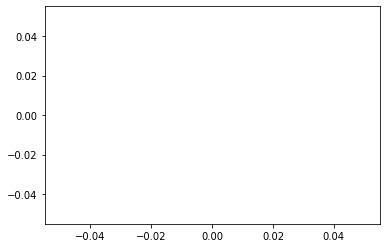

In [0]:
pd.Series(train_loss_history).plot()

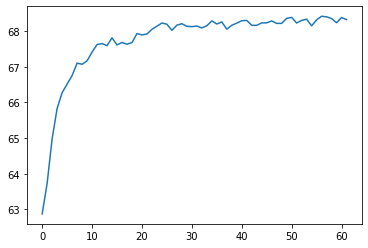

In [0]:
pd.Series(val_accuracy_history).plot()

In [0]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for batch_text, batch_length, batch_labels in dataloader:
            batch_length = batch_length.to(device)
            batch_text = batch_text.to(device)

            #preds = model(batch_text, batch_length)
            preds = model(batch_text)

            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(batch_labels)
    predicted=np.concatenate(all_preds, axis=0)
    label=np.concatenate(all_labels, axis=0)
    accuracy=(np.array(label)==predicted.argmax(-1)).mean()
    return accuracy 



In [0]:
# Reload best model from saved checkpoint
# Compute test accuracy
#model = torch.load('best_model_gender.pt')
#model.to(device)
test_accuracy = evaluate(model, test_loader,device)
print(test_accuracy)

0.6746148852033288


In [0]:
def evaluate_classes(model, dataloader, device):
    correct0 = 0
    correct1 = 0
    correct2 = 0
    total0 = 0
    total1 = 0
    total2 = 0
    model.eval()
    
    with torch.no_grad():
        for batch_text, batch_length, batch_labels in dataloader:
            batch_length = batch_length.to(device)
            batch_text = batch_text.to(device)

            #preds = model(batch_text, batch_length)
            preds = F.softmax(model(batch_text)).argmax(-1)
            preds = preds.detach().cpu().numpy()

            batch_labels = batch_labels.numpy()

            for i in range(preds.shape[0]):
                  lab = batch_labels[i]
                  pred = preds[i]
                  if lab == 0:
                        total0 +=1
                        if pred == 0:
                              correct0 += 1
                  elif lab == 1:
                        total1 +=1
                        if pred == 1:
                              correct1 += 1
                  else:
                        total2 += 1
                        if pred == 2:
                              correct2 += 1
    return correct0/total0, correct1/total1, correct2/total2 

In [0]:
evaluate_classes(model, test_loader,device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


(0.697050709593015, 0.7988610478359909, 0.254572417202175)